**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Práctica 2.  Aprendizaje en entornos complejos**

## **1. Preparación del Entorno**

### 1.1 Introducción.  

Este notebook se enfoca en la implementación y análisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son: 

 - **FrozenLake (4x4)**

 - **FrozenLake (8x8)**

### 1.2. Instalación de Dependencias

Se instalan las librerías necesarias para trabajar con el entorno de simulación `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadrícula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desafíos.

In [63]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium 
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librerías

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random

from src_agents import *

### 1.4 Importación de los Entornos 

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un pequeño lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente útil para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensión de cómo el agente interactúa con el entorno.

- **CliffWalking** el agente aquí debe caminar a lo largo de un acantilado, evitando caer en él. Este entorno introduce más complejidad, ya que las acciones del agente tienen consecuencias más dramáticas, como caer en el acantilado si no se tiene cuidado, lo que ofrece una mayor oportunidad para evaluar la capacidad del agente de aprender de los castigos y recompensas.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempeño del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripción**: Graficará la proporción de recompensas obtenidas en cada episodio del entrenamiento. Este gráfico proporciona una visualización clara del progreso del agente, mostrando cómo mejora su desempeño a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripción**: Graficará la longitud de los episodios en el entrenamiento, y calculará y mostrará la tendencia de las longitudes utilizando una media móvil.

3. `plot_policy_blank(Q, env)`  
   - **Descripción**: Dibuja la política aprendida por el agente sobre un entorno vacío, representando las acciones óptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparación de Resultados de Entrenamiento")`  
   - **Descripción**: Compara la evolución de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparación de Longitudes de Episodios")`  
   - **Descripción**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgráficas separadas, con sombreado y media móvil.

Todas las funciones y clases relacionadas con la visualización de gráficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, será necesario importar las librerías correspondientes desde esa ruta.

## **2. Diseño del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementación de distintos agentes, organizados en módulos específicos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Además, se incluyen módulos auxiliares para definir políticas de exploración y visualizar resultados.

```plaintext
|-- 📂 src_agents                  # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- 📄 __init__.py             # Archivo que convierte el directorio en un paquete de Python
|   |-- 📄 agent.py                # Clase base para todos los agentes
|   |-- 📄 monteCarloOnPolicy.py   # Implementación del agente Monte Carlo On-Policy
|   |-- 📄 monteCarloOffPolicy.py  # Implementación del agente Monte Carlo Off-Policy
|   |-- 📄 qLearning.py            # Implementación del agente Q-Learning
|   |-- 📄 sarsa.py                # Implementación del agente SARSA
|   |-- 📄 politicas.py            # Definición de políticas de exploración como epsilon-greedy y softmax
|   |-- 📄 plotting.py             # Funciones de visualización de datos y gráficos


El diseño del agente consta de dos partes.  

- Las políticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Políticas del Agente

- **Epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida. 
   
- **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.  

- **Política greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentación - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadrícula donde cada celda puede ser suelo firme, un agujero o la meta. 

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versión estándar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la dirección elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se moverá exactamente en la dirección que elija sin desviaciones aleatorias. Esto hace que el problema sea más determinista y permite un aprendizaje más directo de las estrategias óptimas.

El objetivo del agente es llegar a la casilla de meta desde la posición inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una política óptima de manera más eficiente, ya que sus acciones tienen consecuencias predecibles.

### **3.1 Monte Carlo On-Policy**

Monte Carlo (MC) es un método de aprendizaje por refuerzo basado en la simulación de episodios completos para actualizar la función de valor de estado-acción $Q(s,a)$. En el enfoque **On-Policy**, seguimos una política de exploración ($\epsilon$-greedy) y actualizamos $Q$ en función de las recompensas obtenidas.

**Características clave del método Monte Carlo On-Policy**:

- Aprende a partir de episodios completos (del estado inicial al terminal).  
- La actualización de $Q(s,a)$ se realiza utilizando el retorno $G$, que es la recompensa acumulada futura descontada:

  $$
  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1} R_T
  $$

- Utiliza un promedio incremental para actualizar $Q$, en lugar de una tasa de aprendizaje fija:

  $$
  Q(s,a) \leftarrow Q(s,a) + \frac{1}{N(s,a)} (G - Q(s,a))
  $$

  donde $N(s,a)$ es el número de veces que se ha visitado el par $(s,a)$.  
- Sigue una estrategia **On-Policy**, lo que significa que la misma política utilizada para generar episodios también se usa para mejorar $Q$.  

**Ecuación de actualización de $Q(s,a)$:**
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \cdot (G - Q(s,a))
$$

donde:  
- $G$ es el retorno acumulado desde el estado $s$ y la acción $a$.  
- $\alpha$ es un promedio incremental basado en el número de visitas:  

  $$
  \alpha = \frac{1}{N(s,a)}
  $$

#### 3.1.1 Mapa 4x4

**Implementación**  

En primer lugar, establecemos una semilla para la reproducibilidad del problema

In [ ]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

Se crea un entorno de FrozenLake 4x4 sin deslizamiento (``'is_slippery=False'``), lo que hace que el movimiento del agente sea determinista.

In [ ]:
# Crear el entorno
env_mc_on_policy = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

**Creación del agente Monte Carlo On-Policy**

Ahora tenemos que instanciar el agente ``MonteCarloOnPolicy``, con las siguientes característica:

- ``epsilon=0.4``: Inicialmente, el agente explorará con una probabilidad del 40%.  

- ``gamma=1.0``: Se utiliza un factor de descuento completo, lo que significa que se consideran todas las recompensas futuras sin atenuación.

- ``decay=True``: Permite que epsilon disminuya con el tiempo, lo que ayuda al agente a explotar más a medida que aprende.

- ``num_episodios=50000``: El agente se entrena durante 50,000 episodios para garantizar un aprendizaje suficiente.


In [ ]:
# Instanciamos el agente
agente_mc_on_policy = MonteCarloOnPolicy(env_mc_on_policy, epsilon=0.4, gamma=1.0, decay=True, num_episodios=50000)

Luego, se llama al método ``entrenar()``, que devuelve los siguientes resultados:  
 
- ``Q_mc_on_policy``: La Q-table entrenada.  

- ``stats_mc_on_policy``: Una lista con la recompensa media acumulada por episodio.  

- ``episode_lengths_mc_on_policy``: Una lista con la longitud de cada episodio.  

In [ ]:
Q_mc_on_policy, stats_mc_on_policy, episode_lengths_mc_on_policy = agente_mc_on_policy.entrenar()

**Evaluación de la política aprendida**  
Una vez entrenado el agente con el algoritmo Monte Carlo On-Policy, **es fundamental evaluar la política aprendida para comprobar su eficacia en la resolución del entorno**. Para ello, se extrae la política óptima a partir de la Q-table obtenida durante el entrenamiento.

- ``pi_star_from_Q()`` extrae la política óptima a partir de la Q-table entrenada.

- ``actions_mc_on_policy`` contiene la secuencia de acciones óptimas para resolver FrozenLake.

- La política óptima representa la mejor estrategia aprendida por el agente para llegar a la meta.

In [ ]:
pi_star_mc_on_policy, actions_mc_on_policy = pi_star_from_Q(env_mc_on_policy, Q_mc_on_policy)

**Conclusión**

Para evaluar de manera integral el desempeño del agente entrenado, es útil visualizar distintos aspectos clave de su aprendizaje.  

En esta sección, se presentará una función que genera una figura con tres gráficos principales:

- **Proporción de recompensas por episodio**, lo que permite observar cómo evoluciona la capacidad del agente para alcanzar la meta a lo largo del entrenamiento. 

- **Longitud de los episodios**, incluyendo una media móvil para analizar la estabilidad del aprendizaje y la eficiencia del agente en la resolución del entorno. 
 
- **Política aprendida**, representada gráficamente en el entorno de FrozenLake, donde se muestra la mejor acción aprendida mediante flechas direccionales.  

In [ ]:
plot_all_three(
    list_stats=stats_mc_on_policy,
    episode_lengths=episode_lengths_mc_on_policy,
    Q=Q_mc_on_policy,
    env=env_mc_on_policy,
    actions=actions_mc_on_policy,
    window=50  # O el valor que quieras
)


En la gráfica de la **izquierda**, se muestra la **proporción de recompensas** obtenidas por episodio. Se observa una tendencia ascendente, lo que indica que el agente **mejora progresivamente su rendimiento**. Este resultado sugiere que la política aprendida es cada vez más efectiva para maximizar las recompensas en el entorno.

En la gráfica **central**, se representa la **longitud de los episodios**. Al inicio del entrenamiento, la longitud de los episodios es muy variable y, en muchos casos, elevada (se toman más pasos antes de terminar). Sin embargo, con el tiempo se aprecia una **disminución y estabilización** de la duración de los episodios, reforzada por la línea roja de media móvil. Esto evidencia que el agente **aprende a resolver el entorno de forma más eficiente**, reduciendo la cantidad de pasos necesarios para alcanzar un estado terminal (ya sea por caer en un agujero o llegar a la meta).

Por último, en la **derecha** se muestra la **política aprendida** en el tablero de *Frozen Lake*. Cada celda de tipo “F” (hielo seguro) contiene una flecha que indica la **acción óptima** aprendida por el agente. Las celdas “H” (hoyo/agua) y “G” (meta) se marcan en rojo y verde, respectivamente, para señalar que son estados terminales. Este diagrama revela que la política aprendida evita las celdas “H” siempre que sea posible y traza un camino consistente hacia la meta “G”.  

En conjunto, los tres gráficos confirman que:
1. El **rendimiento** del agente (proporción de recompensas) **aumenta** progresivamente.  
2. La **longitud de los episodios** **disminuye**, reflejando una **mayor eficiencia** en la toma de decisiones.  
3. La **política final** conduce al agente a **evitar los hoyos** y **alcanzar la meta** de manera consistente.  

Estos resultados evidencian que el agente ha **convergido** a una solución razonable para la tarea de *FrozenLake*, aprendiendo a **maximizar recompensas** y **minimizar pasos** necesarios para completar cada episodio.

#### 3.1.2 Mapa 8x8

**Implementación**  

En primer lugar, establecemos una semilla para la reproducibilidad del problema

In [ ]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

Creamos el entorno

In [ ]:
# Crear el entorno
env_mc_on_policy8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

Creación del Agente

In [ ]:
agente_mc_on_policy8x8 = MonteCarloOnPolicy(env_mc_on_policy8x8, epsilon=0.4, gamma=1.0, decay=True, num_episodios=50000)

Realizamos el entrenamiento

In [ ]:
Q_mc_on_policy8x8, stats_mc_on_policy8x8, episode_lengths_mc_on_policy8x8 = agente_mc_on_policy8x8.entrenar()

Evaluación de la política

In [ ]:
pi_star_mc_on_policy8x8, actions_mc_on_policy8x8 = pi_star_from_Q(env_mc_on_policy8x8, Q_mc_on_policy8x8)

Conclusión

In [ ]:
plot_all_three(
    list_stats=stats_mc_on_policy8x8,
    episode_lengths=episode_lengths_mc_on_policy8x8,
    Q=Q_mc_on_policy8x8,
    env=env_mc_on_policy8x8,
    actions=actions_mc_on_policy8x8,
    window=50  # O el valor que quieras
)


### 3.2 Monte Carlo Off-Policy

Monte Carlo (MC) es un método de aprendizaje por refuerzo basado en la simulación de episodios completos para actualizar la función de valor de estado-acción $Q(s,a)$. En la variante **Off-Policy**, la política que se utiliza para generar los episodios (política de comportamiento $b$) puede ser distinta de la política objetivo $\pi$ que deseamos aprender. Para corregir el sesgo introducido por el uso de diferentes políticas, se emplea **Weighted Importance Sampling (WIS)**.

Características clave del método Monte Carlo Off-Policy:

- Uso de dos políticas:

    - **Política de comportamiento ($b$)**: En este caso, es $\epsilon$-greedy respecto a la Q-table.  
    - **Política objetivo ($\pi$)**: Determinista (greedy) en base a la Q-table.  

- Simulación de episodios completos:

Al igual que en Monte Carlo On-Policy, el agente aprende al terminar cada episodio. Sin embargo, las trayectorias se obtienen usando la política de comportamiento $b$.

- Corrección con Weighted Importance Sampling:

Cada transición se pondera con un factor de importancia $W$ que mide la razón entre la probabilidad de la acción bajo la política objetivo $\pi$ y la probabilidad de la acción bajo la política de comportamiento $b$. Formalmente:

$$
W \leftarrow W \times \frac{\pi(a_t | s_t)}{b(a_t | s_t)}
$$

Si $\pi(a_t | s_t) = 0$ (es decir, la política objetivo nunca tomaría esa acción), se corta la retropropagación para evitar actualizaciones no representativas.

- Actualización de $Q(s,a)$:

Se realiza de manera incremental, similar al caso On-Policy, pero multiplicando por el factor $W$. Por ejemplo:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha W (G - Q(s,a))
$$

donde $\alpha = \frac{1}{N(s,a)}$ es un promedio incremental basado en el número de visitas al par $(s,a)$.


#### 3.2.1 Mapa 4x4

**Implementación**

En primer lugar, se establece una semilla para la reproducibilidad y se crea un entorno FrozenLake 4x4 sin deslizamiento (``is_slippery=False``).

In [ ]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Creación del entorno
env_mc_off_policy4x4 = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

A continuación, se instancia el agente **MonteCarloOffPolicy**, indicando:

- ``epsilon=0.4``: exploración inicial para la política de comportamiento.  

- ``gamma=1.0``: se consideran todas las recompensas futuras sin descuento.  

- ``decay=True``: para reducir 𝜖 gradualmente.  

- ``num_episodios=50000``: un número grande de episodios para asegurar la convergencia.  

In [ ]:
agente_mc_off_policy4x4 = MonteCarloOffPolicy(env_mc_off_policy4x4, decay=True, num_episodios=50000)

El método `entrenar()` genera episodios siguiendo la política de comportamiento $\epsilon$-greedy.  

Al terminar cada episodio, se calcula el retorno $G$ y se actualiza $Q$ de atrás hacia adelante.  

Cada par $(s,a)$ se corrige con **Weighted Importance Sampling (Weighted IS)**, de modo que las trayectorias sean evaluadas como si provinieran de la política objetivo $\pi$.


In [ ]:
# Entrenar el agente
Q_mc_off_policy4x4, stats_mc_off_policy4x4, episode_lengths_mc_off_policy4x4 = agente_mc_off_policy4x4.entrenar()

**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_Q`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_mc_off_policy`: Matriz que indica la acción óptima en cada estado.  
- `actions_mc_off_policy`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [ ]:
pi_mc_off_policy4x4, actions_mc_off_policy4x4 = pi_star_from_Q(env_mc_off_policy4x4, Q_mc_off_policy4x4)

**Conclusión**

In [ ]:
plot_all_three(
    list_stats = stats_mc_off_policy4x4,
    episode_lengths = episode_lengths_mc_off_policy4x4,
    Q = Q_mc_off_policy4x4,
    env = env_mc_off_policy4x4,
    actions = actions_mc_off_policy4x4,
    window=50 
)

- En la **gráfica de la izquierda**, se observa la **proporción de recompensas** obtenidas por episodio, mostrando un incremento progresivo a lo largo del entrenamiento. Este comportamiento indica que el agente **aprende a maximizar sus recompensas** de forma cada vez más consistente, lo que sugiere una **mejora continua** en su desempeño.

- En la **gráfica central**, se presenta la **longitud de los episodios**. Inicialmente, la duración de los episodios exhibe una gran variabilidad y, con frecuencia, es elevada (el agente necesita más pasos para concluir). Sin embargo, con el avance del entrenamiento se aprecia una **reducción y estabilización** de la longitud de los episodios, confirmada por la curva roja de media móvil. Este resultado refleja que el agente **gana eficiencia** al resolver el entorno, tardando cada vez menos pasos en alcanzar un estado terminal.

- En la **gráfica de la derecha**, se muestra la **política aprendida** sobre el tablero de *FrozenLake*. Cada casilla de tipo “F” (hielo seguro) incluye una flecha que señala la **acción óptima** seleccionada por el agente. Las celdas “H” (hoyo/agua) y “G” (meta) se señalan en rojo y verde, respectivamente, para resaltar que son estados terminales. El diagrama deja ver que el agente **evita sistemáticamente** los hoyos y traza un **camino efectivo** hacia la meta, cumpliendo así su objetivo de maximizar recompensas y minimizar riesgos.

En conjunto, estos tres gráficos evidencian que:
1. El agente **incrementa** su rendimiento (proporción de recompensas) de manera sostenida.  
2. La **longitud de los episodios** se **reduce** con el entrenamiento, denotando un **aumento en la eficiencia** de sus decisiones.  
3. La **política final** logra **esquivar** los hoyos y **llegar** a la meta de manera consistente.

En conclusión, el agente ha **conseguido** una estrategia sólida para afrontar el desafío de *FrozenLake*, **maximizando** las recompensas obtenidas y **minimizando** la cantidad de pasos necesarios para completar cada episodio.

#### 3.2.2 Mapa 8x8

**Implementación**

En primer lugar, se establece una semilla para la reproducibilidad y se crea un entorno FrozenLake 8x8 sin deslizamiento (``is_slippery=False``).

In [ ]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Creación del entorno
env_mc_off_policy8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

A continuación, se instancia el agente **MonteCarloOffPolicy**, indicando:

- ``epsilon=0.4``: exploración inicial para la política de comportamiento.  

- ``gamma=1.0``: se consideran todas las recompensas futuras sin descuento.  

- ``decay=True``: para reducir 𝜖 gradualmente.  

- ``num_episodios=50000``: un número grande de episodios para asegurar la convergencia.  

In [ ]:
agente_mc_off_policy8x8 = MonteCarloOffPolicy(env_mc_off_policy8x8, decay=True, num_episodios=100000)

El método `entrenar()` genera episodios siguiendo la política de comportamiento $\epsilon$-greedy.  

Al terminar cada episodio, se calcula el retorno $G$ y se actualiza $Q$ de atrás hacia adelante.  

Cada par $(s,a)$ se corrige con **Weighted Importance Sampling (Weighted IS)**, de modo que las trayectorias sean evaluadas como si provinieran de la política objetivo $\pi$.


In [ ]:
Q_mc_off_policy8x8, stats_mc_off_policy8x8, episode_lengths_mc_off_policy8x8 = agente_mc_off_policy8x8.entrenar()

**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_Q`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_mc_off_policy`: Matriz que indica la acción óptima en cada estado.  
- `actions_mc_off_policy`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [ ]:
pi_mc_off_policy8x8, actions_mc_off_policy8x8 = pi_star_from_Q(env_mc_off_policy8x8, Q_mc_off_policy8x8)

In [ ]:
plot_all_three(
    list_stats = stats_mc_off_policy8x8,
    episode_lengths = episode_lengths_mc_off_policy8x8,
    Q = Q_mc_off_policy8x8,
    env = env_mc_off_policy8x8,
    actions = actions_mc_off_policy8x8,
    window=50 
)

### 3.3 SARSA

SARSA (State-Action-Reward-State-Action) se caracteriza por actualizar la función de valor de estado-acción $Q(s,a)$ en cada paso del episodio, utilizando la siguiente ecuación base:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s,a) \right]
$$

donde:

- $s$ y $a$ son el estado y la acción actuales,
- $R_{t+1}$ es la recompensa obtenida tras ejecutar $a$,
- $s_{t+1}$ y $a_{t+1}$ son el estado y la acción siguientes,
- $\alpha$ es la tasa de aprendizaje,
- $\gamma$ es el factor de descuento.

A diferencia de **Q-Learning**, que usa la mejor acción posible en el estado siguiente ($\max_{a'} Q(s_{t+1}, a')$) para actualizar $Q$, **SARSA** emplea la acción real que se va a tomar ($a_{t+1}$), siguiendo la misma política que genera los datos.

**Características Clave de SARSA**

- On-Policy:
La misma política ($\epsilon$-greedy) se usa para explorar (generar la acción $a_{t+1}$) y para actualizar la Q-table.

- Actualización Paso a Paso (TD(0)):
El agente no espera a que finalice el episodio; tras cada transición $(s,a,r,s')$, se selecciona $a'$ y se actualiza $Q(s,a)$ en función de $Q(s',a')$.

- Equilibrio entre Exploración y Explotación:
Con $\epsilon$-greedy, el agente explora con probabilidad $\epsilon$ y explota (selecciona la mejor acción) con probabilidad $1-\epsilon$.

#### 3.3.1 Mapa 4x4

**Implementación**  

En el archivo ``sarsa.py``, hemos implementado la clase SARSA que extiende de Agente.

- `exploration_rate` ($\epsilon$):
Controla la probabilidad de explorar.  
Con valor 0.9, significa que, inicialmente, el agente elegirá una acción aleatoria el 90% de las veces y la mejor acción el 10% de las veces.  
A medida que el agente aprende, este valor puede decaer para favorecer la explotación de lo aprendido.

- `discount_rate` ($\gamma$):
Es el factor de descuento para las recompensas futuras.  
Un valor cercano a 1.0 indica que el agente tiene en cuenta casi en su totalidad las recompensas lejanas en el tiempo.

- `learning_rate` ($\alpha$):
Determina cuánto se ajusta la Q-table en cada actualización.  
Un valor de 0.1 significa que, en cada paso, el agente corrige su estimación de $Q(s,a)$ en un 10% de la diferencia entre la estimación actual y la nueva información recibida.

- `exploration_decay_rate`:
Es la tasa de decaimiento de la probabilidad de exploración ($\epsilon$).  
Cuanto mayor sea este valor, más rápidamente se reducirá la probabilidad de que el agente tome acciones aleatorias, enfocándose cada vez más en la acción óptima según la Q-table.

- `min_exploration_rate`:
Es el límite inferior de la tasa de exploración.  
Evita que $\epsilon$ se vuelva tan pequeño que el agente deje de explorar por completo. Con 0.01, se garantiza al menos un 1% de probabilidad de explorar incluso en etapas avanzadas del entrenamiento.

- `seed`:
Semilla para la reproducibilidad de resultados.  
Asegura que, usando el mismo valor, se obtenga el mismo comportamiento aleatorio (mismas acciones exploratorias) en sucesivas ejecuciones, facilitando la comparación de experimentos.


In [ ]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  
random.seed(seed_value) 

# Definir los hiperparámetros
hiperparametros_sarsa = {
    "exploration_rate": 0.9,
    "discount_rate": 0.99,
    "learning_rate": 0.1,
    "exploration_decay_rate": 0.001,
    "min_exploration_rate": 0.01,
    "seed": 1995
}

Después, se crea un entorno FrozenLake 4x4 sin deslizamiento (``is_slippery=False``) se le pasan estos parametros e pasa todo esto al constructor de Agente para configurar la semilla, la Q-table y los demás elementos para su correcto funcionamiento.

In [ ]:
# Creación del entorno
env_sarsa = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear el agente SARSA
agente_sarsa = SARSA(env_sarsa, hiperparametros_sarsa)

Conitnuamos con el entrenamiento.

In [ ]:
Q_sarsa, stats_sarsa, episode_lengths_sarsa = agente_sarsa.entrenar(num_episodios=50000)

**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_sarsa`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_star_sarsa`: Matriz que indica la acción óptima en cada estado.  
- `actions_sarsa`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [ ]:
pi_star_sarsa, actions_sarsa = pi_star_from_Q(env_sarsa, Q_sarsa)

**Conclusión**

In [ ]:
plot_all_three(
    list_stats=stats_sarsa,
    episode_lengths=episode_lengths_sarsa,
    Q=Q_sarsa,
    env=env_sarsa,
    actions=actions_sarsa,
    window=50  # O el valor que quieras
)

- En la **gráfica de la izquierda**, se aprecia la **proporción de recompensas** obtenidas por episodio, con una **rápida convergencia** hacia valores cercanos al máximo. Esto indica que el agente **aprende de forma acelerada** a obtener recompensas y a resolver el entorno de manera efectiva.

- En la **gráfica central**, se muestra la **longitud de los episodios**, junto con una **media móvil** para facilitar la observación de la tendencia. Se ve que, al inicio, la duración de los episodios es **altamente variable** y, con frecuencia, elevada. Sin embargo, conforme avanza el entrenamiento, la longitud se **reduce** de forma considerable y se **estabiliza** en valores bajos. Esto evidencia que el agente **descubre** un camino más eficiente para llegar a la meta, necesitando menos pasos para completar cada episodio.

- En la **gráfica de la derecha**, se ilustra la **política aprendida** en el tablero de *FrozenLake*. Las celdas “F” (hielo seguro) contienen **flechas** que indican la **acción óptima**; las celdas “H” (hoyo/agua) y “G” (meta) se colorean en rojo y verde, respectivamente, para recalcar que son estados terminales. El diagrama revela que la política **evita** los hoyos y traza un **camino eficaz** hacia la meta.  

En conjunto, los tres gráficos muestran que:
1. El **rendimiento** (proporción de recompensas) **alcanza** rápidamente niveles cercanos al óptimo.  
2. La **longitud de los episodios** se **reduce** de manera sustancial, demostrando **mayor eficiencia** en la resolución del entorno.  
3. La **política final** permite al agente **evitar** sistemáticamente los hoyos y **llegar** a la meta con un **número mínimo de pasos**.  

Estos resultados evidencian que el agente ha logrado **aprender** una estrategia sólida y **convergido** satisfactoriamente al reto de *FrozenLake*.

#### 3.3.2 Mapa 8x8

**Implementación**  

In [ ]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  
random.seed(seed_value) 

# Definir los hiperparámetros
hiperparametros_sarsa = {
    "exploration_rate": 0.9,
    "discount_rate": 0.99,
    "learning_rate": 0.1,
    "exploration_decay_rate": 0.001,
    "min_exploration_rate": 0.01,
    "seed": 1995
}

Creamos entorno y agente

In [ ]:
# Creación del entorno
env_sarsa8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Crear el agente SARSA
agente_sarsa8x8 = SARSA(env_sarsa8x8, hiperparametros_sarsa)

Entrenamos

In [ ]:
Q_sarsa8x8, stats_sarsa8x8, episode_lengths_sarsa8x8 = agente_sarsa8x8.entrenar(num_episodios=100000)

Evaluamos la política

In [ ]:
pi_star_sarsa8x8, actions_sarsa8x8 = pi_star_from_Q(env_sarsa8x8, Q_sarsa8x8)

**Conclusión**

In [ ]:
plot_all_three(
    list_stats=stats_sarsa8x8,
    episode_lengths=episode_lengths_sarsa8x8,
    Q=Q_sarsa8x8,
    env=env_sarsa8x8,
    actions=actions_sarsa8x8,
    window=50  # O el valor que quieras
)

### 3.4 Q_Learning

Q-Learning es un método de aprendizaje temporal-diferido (TD) que permite al agente aprender la función de valor de estado-acción $Q(s,a)$ sin requerir una política específica para generar los datos (por ello, se considera un método Off-Policy). A diferencia de SARSA, donde se utiliza la acción efectivamente seleccionada ($a_{t+1}$), en Q-Learning se actualiza $Q(s,a)$ basándose en la mejor acción posible en el estado siguiente:

$$
\max_{a'} Q(s', a')
$$

independientemente de la acción que realmente se elija para la exploración.

- Ecuación de Actualización de Q-Learning

En cada paso, tras observar la transición $(s,a,r,s')$, se aplica:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$

donde:

- $s$, $a$ son el estado y la acción antes de la transición.
- $r$ es la recompensa inmediata.
- $s'$ es el nuevo estado tras ejecutar la acción $a$.
- $\max_{a'} Q(s', a')$ denota el mejor valor de acción en el estado siguiente (vista Off-Policy).
- $\alpha$ es la tasa de aprendizaje.
- $\gamma$ es el factor de descuento.

Con este enfoque, la actualización de $Q$ no depende de la acción que se tome realmente en $s'$ para explorar, sino que asume que se elegirá la acción óptima. Por ello, Q-Learning converge a la política óptima si se exploran suficientemente todos los estados y acciones (por ejemplo, usando $\epsilon$-greedy con decaimiento de $\epsilon$).


#### 3.4.1 Mapa 4x4

**Implementación**

Comenzamos seleccionando una semilla para la repetibilidad del ejercicio y seleccionamos los hiperparámetros con los que vamos a trabajar.

- **``learning_rate ($\alpha$)``**

    Controla la velocidad a la que se actualizan los valores $Q(s,a)$.
    - Un valor alto ($\alpha \approx 1$) hace que el agente se adapte muy rápido a la nueva información, pero puede ser inestable.
    - Un valor bajo ($\alpha \approx 0$) hace que el agente aprenda de forma más lenta y conservadora.

- **``discount_rate ($\gamma$)``**

    Factor de descuento que pondera la importancia de las recompensas futuras.
    - Un valor cercano a 1 ($\gamma \approx 1$) indica que el agente considera fuertemente las recompensas lejanas.
    - Un valor cercano a 0 ($\gamma \approx 0$) hace que el agente se centre casi exclusivamente en la recompensa inmediata.

- **``exploration_rate ($\epsilon$)``**

    Probabilidad de que el agente elija una acción aleatoria (exploración) en lugar de la acción con mejor valor $Q$ (explotación).
    - Un valor alto ($\epsilon \approx 1$) implica mucha exploración; un valor bajo ($\epsilon \approx 0$) favorece la explotación.

- **``exploration_decay_rate``**

    Tasa a la que $\epsilon$ disminuye a lo largo de los episodios.
    - Cuanto mayor sea, más rápido se reduce la exploración y se potencia la explotación de la política aprendida.
    - 'min_exploration_rate'

- **``Límite inferior para $\epsilon$.``**
    - Garantiza que el agente mantenga cierta probabilidad de explorar incluso en fases avanzadas del entrenamiento, evitando que $\epsilon$ llegue a 0.

- **``seed``**
    - Asegura que los elementos aleatorios (acciones, inicializaciones) puedan replicarse en sucesivas ejecuciones, permitiendo comparar resultados de forma consistente.


In [ ]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)

# Parámetros para el agente
hiperparametros_ql = {
    'learning_rate': 0.1,
    'discount_rate': 0.99,
    'exploration_rate': 1.0,
    'exploration_decay_rate': 0.001,
    'min_exploration_rate': 0.01,
    'seed': seed_value  # Pasamos la semilla al agente
}

Luego, creamos el entorno, realizamos la creación del agente y comenzamos con el entrenamiento

In [ ]:
env_ql = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")
env_ql.reset(seed=seed_value)
agente_ql = QLearning(env_ql, hiperparametros_ql)
Q_ql, stats_ql, episode_lengths_ql = agente_ql.entrenar(num_episodios=50000)

**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_Q`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_ql`: Matriz que indica la acción óptima en cada estado.  
- `actions_ql`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [ ]:

pi_star_ql, actions_ql = pi_star_from_Q(env_ql, Q_ql)


**Conclusión**

In [ ]:
plot_all_three(
    list_stats=stats_ql,
    episode_lengths=episode_lengths_ql,
    Q=Q_ql,
    env=env_ql,
    actions=actions_ql,
    window=50  # O el valor que quieras
)

- En la **gráfica de la izquierda**, la **proporción de recompensas** por episodio crece de manera **rápida** y se acerca a un valor muy alto, lo que indica que el agente **aprende con eficacia** a maximizar sus recompensas. Esta tendencia ascendente sugiere que la política aprendida es cada vez más **efectiva** para alcanzar la meta y evitar los agujeros.

- En la **gráfica central**, se muestra la **longitud de los episodios**, junto con una **media móvil** que suaviza la curva. Se ve que, tras un periodo inicial de alta variabilidad, la longitud de los episodios **disminuye** de manera notable y se **estabiliza**. Este resultado confirma que el agente **descubre** progresivamente estrategias más eficientes para resolver el entorno, necesitando menos pasos para llegar a un estado terminal.

- En la **gráfica de la derecha** ilustra la **política aprendida** en el tablero de *FrozenLake*. Cada celda de tipo “F” (hielo seguro) incluye una **flecha** que marca la **acción óptima**. Las celdas “H” (hoyo/agua) y “G” (meta) se representan en rojo y verde, respectivamente, indicando que son estados terminales. El diagrama revela que la política final **evita** sistemáticamente los hoyos y traza un **camino efectivo** hacia la meta.

En conjunto, estos tres gráficos evidencian que:

1. El agente **alcanza** rápidamente un **alto rendimiento** (proporción de recompensas).  
2. La **longitud de los episodios** se **reduce** y se estabiliza, reflejando **mayor eficiencia** en la toma de decisiones.  
3. La **política final** esquiva los hoyos y dirige al agente hacia la meta, confirmando una **estrategia sólida** para completar FrozenLake.

#### 3.4.2 Mapa 8x8

In [ ]:
# plot_comparison([stats_mc_off_policy, stats_mc_on_policy, stats_sarsa,stats_ql], labels=["MC Off-Policy","MC On-Policy", "SARSA","Q-Learning"])
# plot_episode_lengths_comparison([episode_lengths_mc_off_policy, episode_lengths_mc_on_policy, episode_lengths_sarsa,episode_lengths_ql], labels=["MC Off-Policy","MC On-Policy", "SARSA","Q-Learning"])


## **4. Conclusión**

In [ ]:
pi_star_ql, actions_ql = pi_star_from_Q(entorno, Q_sarsa)
plot_all_three(
    list_stats=stats_sarsa,
    episode_lengths=episode_lengths_sarsa,
    Q=Q_sarsa,
    env=entorno,
    actions=actions_ql,
    window=50  # O el valor que quieras
)

In [ ]:
import gymnasium as gym

class FrozenLakeWrapper:
    def __init__(self, is_slippery=True):
        # Se crea el entorno de FrozenLake con la configuración deseada.
        self.env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
        self.action_space = self.env.action_space  # Espacio de acciones (discreto)
        self.observation_space = self.env.observation_space  # Espacio de observaciones (discreto)

    def reset(self):
        # Gymnasium puede devolver (observation, info). Nos quedamos con la observación.
        result = self.env.reset()
        if isinstance(result, tuple):
            return result[0]
        return result

    def step(self, action):
        # En Gymnasium step() devuelve: (observation, reward, terminated, truncated, info)
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
            return obs, reward, done, info
        else:
            return result

    def render(self):
        # Llamamos a render() directamente del entorno
        self.env.render()


In [ ]:
import numpy as np

class MonteCarloAgent:
    def __init__(self, env, on_policy=True, discount_rate=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.995):
        self.env = env
        self.on_policy = on_policy  # En este ejemplo se asume on-policy
        self.discount_rate = discount_rate
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate

        # Crear la Q-table. Frozen Lake tiene un número finito de estados y acciones.
        num_states = self.env.observation_space.n
        num_actions = self.env.action_space.n
        self.Q = np.zeros((num_states, num_actions))
        
        # Diccionario para almacenar la lista de retornos para cada par (estado, acción)
        self.returns = {}

    def choose_action(self, state):
        # Política epsilon-greedy:
        # Con probabilidad epsilon se elige una acción aleatoria (exploración)
        # y con 1-epsilon se elige la acción con mayor Q (explotación).
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state, :])

    def generate_episode(self):
        episode = []
        state = self.env.reset()
        done = False

        while not done:
            action = self.choose_action(state)
            next_state, reward, done, info = self.env.step(action)
            # Guardamos la tupla (estado, acción, recompensa)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_Q(self, episode):
        G = 0  # Retorno acumulado
        # Recorremos el episodio de atrás hacia adelante
        for state, action, reward in reversed(episode):
            G = self.discount_rate * G + reward
            # Guardamos el retorno G para el par (state, action)
            if (state, action) not in self.returns:
                self.returns[(state, action)] = []
            self.returns[(state, action)].append(G)
            # Actualizamos Q como la media de los retornos obtenidos para ese par
            self.Q[state, action] = np.mean(self.returns[(state, action)])

    def decay_epsilon(self):
        # Disminuye epsilon pero sin que caiga por debajo del mínimo establecido.
        self.epsilon = max(self.epsilon * self.decay_rate, self.min_epsilon)


In [ ]:
# Crear el entorno env_wrapper usando nuestro FrozenLakeWrapper
env_wrapper = FrozenLakeWrapper(is_slippery=True)

# Crear el agente Monte Carlo
agent = MonteCarloAgent(env_wrapper, discount_rate=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.995)

# Número de episodios de entrenamiento
num_episodes = 10000

for i in range(num_episodes):
    episode = agent.generate_episode()
    agent.update_Q(episode)
    agent.decay_epsilon()

# Evaluación de la política aprendida
state = env_wrapper.reset()
done = False
print("Evaluando la política aprendida...")
while not done:
    # Se elige la acción con mayor valor en Q (estrategia greedy)
    action = np.argmax(agent.Q[state, :])
    state, reward, done, info = env_wrapper.step(action)
    env_wrapper.render()


Episode 50, Average Reward: 0.00, Epsilon: 0.78
Episode 100, Average Reward: 0.08, Epsilon: 0.61
Episode 150, Average Reward: 0.18, Epsilon: 0.47
Episode 200, Average Reward: 0.06, Epsilon: 0.37
Episode 250, Average Reward: 0.06, Epsilon: 0.29
Episode 300, Average Reward: 0.52, Epsilon: 0.22
Episode 350, Average Reward: 0.84, Epsilon: 0.17
Episode 400, Average Reward: 0.78, Epsilon: 0.13
Episode 450, Average Reward: 0.82, Epsilon: 0.10
Episode 500, Average Reward: 0.90, Epsilon: 0.08
Episode 550, Average Reward: 0.90, Epsilon: 0.06
Episode 600, Average Reward: 0.98, Epsilon: 0.05
Episode 650, Average Reward: 0.96, Epsilon: 0.04
Episode 700, Average Reward: 0.98, Epsilon: 0.03
Episode 750, Average Reward: 0.98, Epsilon: 0.02
Episode 800, Average Reward: 0.98, Epsilon: 0.02
Episode 850, Average Reward: 0.98, Epsilon: 0.01
Episode 900, Average Reward: 0.98, Epsilon: 0.01
Episode 950, Average Reward: 1.00, Epsilon: 0.01
Episode 1000, Average Reward: 1.00, Epsilon: 0.01


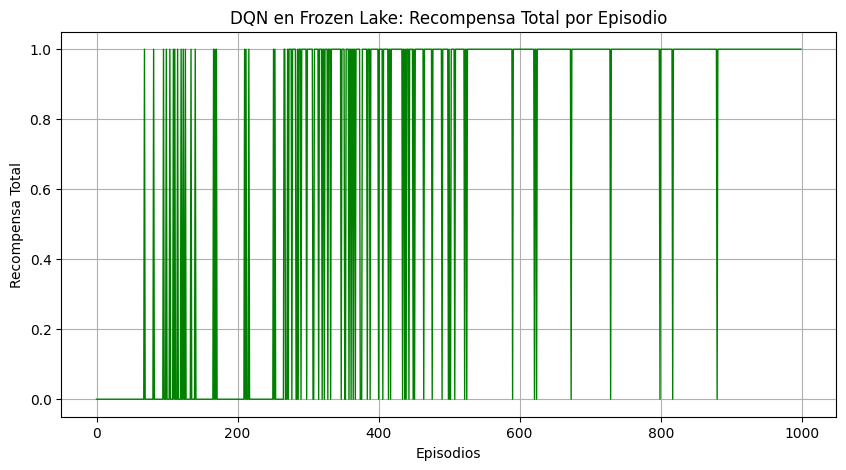

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# -------------------------------------------------
# Definición de la red neuronal (DQN)
# -------------------------------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------------------------
# Replay Buffer para almacenar transiciones
# -------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones
    
    def __len__(self):
        return len(self.buffer)

# -------------------------------------------------
# Función para convertir un estado discreto en vector one-hot
# -------------------------------------------------
def one_hot(state, state_size):
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state] = 1.0
    return vec

# -------------------------------------------------
# Parámetros e inicialización del entorno y el agente
# -------------------------------------------------
env = gym.make('FrozenLake-v1', is_slippery=False)
state_size = env.observation_space.n   # Por ejemplo, 16 para FrozenLake-v1 4x4
action_size = env.action_space.n         # Normalmente 4 acciones

hidden_size = 64
learning_rate = 0.001
gamma = 0.99

epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995

buffer_capacity = 10000
batch_size = 64
num_episodes = 1000
target_update = 10  # Actualizamos la red objetivo cada 10 episodios

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Redes y optimizador
policy_net = DQN(state_size, action_size, hidden_size).to(device)
target_net = DQN(state_size, action_size, hidden_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(buffer_capacity)

# -------------------------------------------------
# Ciclo de entrenamiento
# -------------------------------------------------
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset(seed=1995)  # Gymnasium devuelve (estado, info)
    state = one_hot(state, state_size)
    total_reward = 0
    done = False

    while not done:
        # Selección de acción: política epsilon-greedy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, device=device).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()
        
        # Ejecutar acción en el entorno
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state_one_hot = one_hot(next_state, state_size)
        
        replay_buffer.push(state, action, reward, next_state_one_hot, done)
        state = next_state_one_hot
        total_reward += reward
        
        # Actualización de la red si el buffer tiene suficientes muestras
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            states = torch.tensor(states, device=device)
            actions = torch.tensor(actions, device=device).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device)
            next_states = torch.tensor(next_states, device=device)
            dones = torch.tensor(dones, device=device, dtype=torch.float32)
            
            # Q(s,a) para las transiciones del batch
            q_values = policy_net(states).gather(1, actions).squeeze(1)
            with torch.no_grad():
                max_next_q_values = target_net(next_states).max(1)[0]
                target = rewards + gamma * max_next_q_values * (1 - dones)
            
            loss = nn.MSELoss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    episode_rewards.append(total_reward)
    epsilon = max(epsilon * epsilon_decay, min_epsilon)
    
    if (episode+1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1}, Average Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")
    
    # Actualización periódica de la red objetivo
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

# -------------------------------------------------
# Graficar la recompensa total por episodio
# -------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(num_episodes), episode_rewards, color='green', linewidth=1)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Total")
plt.title("DQN en Frozen Lake: Recompensa Total por Episodio")
plt.grid(True)
plt.show()


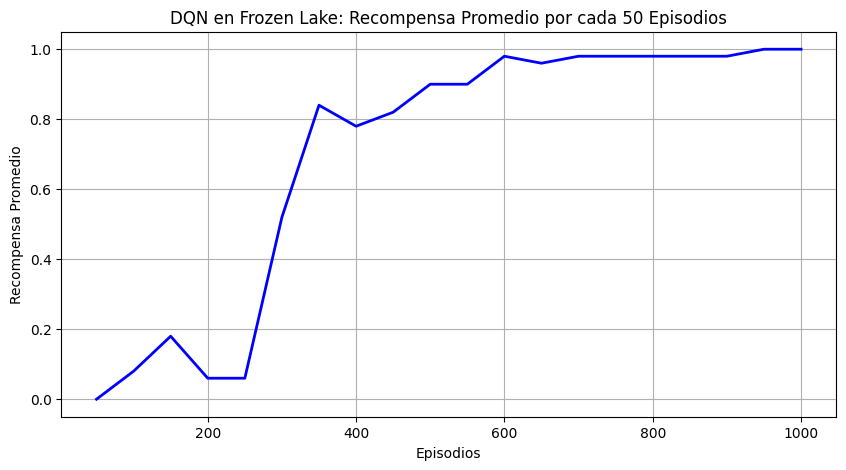

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el tamaño de la ventana para el promedio (por ejemplo, 50 episodios)
window_size = 50
avg_rewards = []
# Calcular la recompensa promedio para cada ventana de episodios
for i in range(0, len(episode_rewards), window_size):
    window_avg = np.mean(episode_rewards[i:i+window_size])
    avg_rewards.append(window_avg)

# Generar los ejes: cada punto representa el final de la ventana
x = np.arange(window_size, num_episodes+1, window_size)

plt.figure(figsize=(10, 5))
plt.plot(x, avg_rewards, color='blue', linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Promedio")
plt.title("DQN en Frozen Lake: Recompensa Promedio por cada 50 Episodios")
plt.grid(True)
plt.show()


C:\Users\pacol\AppData\Local\Temp\ipykernel_6108\2491355351.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Episode 50, Average Reward: 0.00, Epsilon: 0.78
Episode 100, Average Reward: 0.00, Epsilon: 0.61
Episode 150, Average Reward: 0.00, Epsilon: 0.47
Episode 200, Average Reward: 0.00, Epsilon: 0.37
Episode 250, Average Reward: 0.00, Epsilon: 0.29
Episode 300, Average Reward: 0.00, Epsilon: 0.22
Episode 350, Average Reward: 0.02, Epsilon: 0.17
Episode 400, Average Reward: 0.18, Epsilon: 0.13
Episode 450, Average Reward: 0.70, Epsilon: 0.10
Episode 500, Average Reward: 0.88, Epsilon: 0.10
Episode 550, Average Reward: 0.90, Epsilon: 0.10
Episode 600, Average Reward: 0.90, Epsilon: 0.10
Episode 650, Average Reward: 0.84, Epsilon: 0.10
Episode 700, Average Reward: 0.90, Epsilon: 0.10
Episode 750, Average Reward: 0.90, Epsilon: 0.10
Episode 800, Average Reward: 0.92, Epsilon: 0.10
Episode 850, Average Reward: 0.68, Epsilon: 0.10
Episode 900, Average Reward: 0.76, Epsilon: 0.10
Episode 950, Average Reward: 0.98, Epsilon: 0.10
Episode 1000, Average Reward: 0.94, Epsilon: 0.10
Episode 1050, Averag

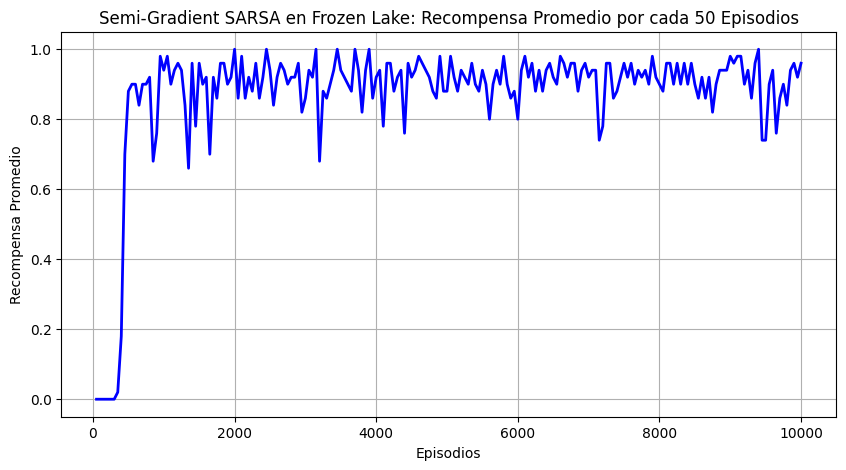

In [68]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# -------------------------------------------------
# Función para convertir el estado discreto a vector one-hot
# -------------------------------------------------
def one_hot(state, state_size):
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state] = 1.0
    return vec

# -------------------------------------------------
# Wrapper para el entorno Frozen Lake
# -------------------------------------------------
class FrozenLakeWrapper:
    def __init__(self, is_slippery=True):
        self.env = gym.make('FrozenLake-v1', is_slippery=is_slippery, map_name="8x8")
        self.action_space = self.env.action_space  # Discrete(4)
        self.observation_space = self.env.observation_space  # Discrete(n)
    
    def reset(self):
        # En Gymnasium reset() devuelve (observation, info)
        result = self.env.reset(seed=1995)
        if isinstance(result, tuple):
            return result[0]
        return result
    
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
            return obs, reward, done, info
        else:
            return result
    
    def render(self):
        self.env.render()

# -------------------------------------------------
# Definición de la red neuronal para SARSA
# -------------------------------------------------
class SarsaNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(SarsaNet, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------------------------
# Agente SARSA con aproximación semigradiente
# -------------------------------------------------
class SarsaAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                 epsilon=1.0, min_epsilon=0.1, decay_rate=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        
        self.model = SarsaNet(state_size, action_size, hidden_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
    
    def choose_action(self, state):
        # Política epsilon-greedy
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state_tensor)
            return q_values.argmax().item()
    
    def update(self, state, action, reward, next_state, next_action, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        
        # Q(s, a) actual
        q_value = self.model(state_tensor)[0, action]
        
        with torch.no_grad():
            if done:
                target = reward
            else:
                target = reward + self.gamma * self.model(next_state_tensor)[0, next_action]
        target = torch.tensor(target)
        
        loss = self.criterion(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.decay_rate, self.min_epsilon)

# -------------------------------------------------
# Integración y entrenamiento
# -------------------------------------------------

# Crear el entorno (Frozen Lake) y definir dimensiones
env_wrapper = FrozenLakeWrapper(is_slippery=False)
state_size = env_wrapper.observation_space.n   # Ej: 16 para 4x4
action_size = env_wrapper.action_space.n         # Normalmente 4

# Crear el agente SARSA
agent = SarsaAgent(state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                   epsilon=1.0, min_epsilon=0.1, decay_rate=0.995)

num_episodes = 10000
episode_rewards = []  # Para almacenar la recompensa total de cada episodio

for episode in range(num_episodes):
    state = env_wrapper.reset()
    state_one_hot = one_hot(state, state_size)
    action = agent.choose_action(state_one_hot)
    total_reward = 0
    done = False
    
    while not done:
        next_state, reward, done, info = env_wrapper.step(action)
        next_state_one_hot = one_hot(next_state, state_size)
        # Si el episodio continúa, elegimos la siguiente acción
        next_action = agent.choose_action(next_state_one_hot) if not done else None
        
        # Actualización en línea: semi-gradient SARSA
        agent.update(state_one_hot, action, reward, next_state_one_hot, next_action, done)
        
        state_one_hot = next_state_one_hot
        action = next_action if not done else None
        total_reward += reward
        
    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1}, Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

# -------------------------------------------------
# Graficar la recompensa promedio cada 50 episodios
# -------------------------------------------------
window_size = 50
avg_rewards = []
for i in range(0, len(episode_rewards), window_size):
    window_avg = np.mean(episode_rewards[i:i+window_size])
    avg_rewards.append(window_avg)

x = np.arange(window_size, num_episodes + 1, window_size)

plt.figure(figsize=(10, 5))
plt.plot(x, avg_rewards, color='blue', linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Promedio")
plt.title("Semi-Gradient SARSA en Frozen Lake: Recompensa Promedio por cada 50 Episodios")
plt.grid(True)
plt.show()


In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_three(list_stats, episode_lengths, Q, env, actions, window=50):
    """
    Muestra en una sola figura:
      1) Proporción de recompensas por episodio.
      2) Longitud de los episodios (con media móvil).
      3) Política aprendida en el entorno (flechas).

    Además, se incluye un parámetro `actions` (lista de enteros 0..3) que
    se mostrará en la leyenda como "Política escogida por el agente".

    Parámetros:
    -----------
    list_stats : list
        Lista con los valores de recompensas por episodio.
    episode_lengths : list
        Lista con la longitud de cada episodio.
    Q : np.ndarray
        Q-table con dimensiones [n_estados, n_acciones].
    env : gym.Env
        Entorno de Gymnasium (ej. FrozenLake-v1).
    actions : list[int]
        Lista de enteros (0,1,2,3) que representan la política escogida por el agente.
    window : int
        Tamaño de la ventana para calcular la media móvil de la longitud de episodios.
    """

    # Crear la figura con 3 subplots en una sola fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # ──────────────────────────────
    # 1) Proporción de recompensas
    # ──────────────────────────────
    indices = list(range(len(list_stats)))
    ax1.plot(indices, list_stats, label="Proporción de recompensas", color="blue")
    ax1.set_title("Proporción de Recompensas")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Proporción")
    ax1.grid(True)
    ax1.legend()

    # ─────────────────────────────────────────────────────
    # 2) Longitud de episodios (con media móvil opcional)
    # ─────────────────────────────────────────────────────
    indices = list(range(len(episode_lengths)))
    ax2.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6, color="green")

    # Calcular y trazar la media móvil si hay suficientes episodios
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window) / window, mode="valid")
        ax2.plot(range(window - 1, len(episode_lengths)), moving_avg,
                 label=f"Media Móvil (window={window})", color='red', linewidth=2)

    ax2.set_title("Longitud de los Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.grid(True)
    ax2.legend()

    # ────────────────────────────────────────────────────────────
    # 3) Política aprendida (flechas en un mapa FrozenLake)
    # ────────────────────────────────────────────────────────────

    # Mapeo de índice de acción -> símbolo de flecha
    arrow_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}

    # Obtener las dimensiones del mapa (número de filas y columnas)
    num_filas, num_columnas = env.unwrapped.desc.shape

    # Para cada estado, calcular la mejor acción según Q-table
    best_actions = [np.argmax(Q[s]) for s in range(env.observation_space.n)]
    best_actions_2d = np.reshape(best_actions, (num_filas, num_columnas))

    # Ajustar límites del subplot para que coincidan con el grid
    ax3.set_xlim(-0.5, num_columnas - 0.5)
    ax3.set_ylim(num_filas - 0.5, -0.5)

    # Pintar cada celda según su tipo (S, F, H, G)
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                color = "gray"
            elif celda == 'G':
                color = "green"
            elif celda == 'F':
                color = "skyblue"
            elif celda == 'H':
                color = "red"
            else:
                color = "white"

            ax3.add_patch(plt.Rectangle((columna - 0.5, fila - 0.5),
                                        1, 1, color=color, ec="black"))

    # Añadir texto: para 'S' se muestra "Start", para 'H' y 'G' se muestra la letra,
    # y para 'F' se muestra la flecha de la acción óptima
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                ax3.text(columna, fila, "Start", ha="center", va="center",
                         fontsize=12, color="white", fontweight="bold")
            elif celda in ['H', 'G']:
                ax3.text(columna, fila, celda, ha="center", va="center",
                         fontsize=14, color="white", fontweight="bold")
            else:
                accion_optima = best_actions_2d[fila, columna]
                flecha = arrow_dict.get(accion_optima, '?')
                ax3.text(columna, fila, flecha, ha="center", va="center",
                         fontsize=16, color="black", fontweight="bold")

    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Política Aprendida (Monte Carlo On-Policy)", pad=10)

    # ────────────────────────────────────────────────────────────
    # Leyenda de flechas y colores
    # ────────────────────────────────────────────────────────────
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches

    left_arrow = mlines.Line2D([], [], color='black', marker=r'$\leftarrow$', 
                               linestyle='None', markersize=12, label='Acción 0: Izquierda')
    down_arrow = mlines.Line2D([], [], color='black', marker=r'$\downarrow$', 
                               linestyle='None', markersize=12, label='Acción 1: Abajo')
    right_arrow = mlines.Line2D([], [], color='black', marker=r'$\rightarrow$', 
                                linestyle='None', markersize=12, label='Acción 2: Derecha')
    up_arrow = mlines.Line2D([], [], color='black', marker=r'$\uparrow$', 
                             linestyle='None', markersize=12, label='Acción 3: Arriba')
    patch_s = mpatches.Patch(color="gray", label="S (Inicio)")
    patch_f = mpatches.Patch(color="skyblue", label="F (Hielo)")
    patch_h = mpatches.Patch(color="red", label="H (Agua)")
    patch_g = mpatches.Patch(color="green", label="G (Meta)")

    # Convertir la lista de acciones en cadena para mostrar en la leyenda
    policy_str = str(actions)
    policy_line = mlines.Line2D([], [], color='none', marker='',
                                linestyle='None', label=f"\n Política escogida: {policy_str}")

    legend_handles = [
        left_arrow, down_arrow, right_arrow, up_arrow,
        patch_s, patch_f, patch_h, patch_g,
        policy_line
    ]

    ax3.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
               loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()


C:\Users\pacol\AppData\Local\Temp\ipykernel_6108\1211034295.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Episode 50, Average Reward: 0.00, Epsilon: 0.78
Episode 100, Average Reward: 0.04, Epsilon: 0.61
Episode 150, Average Reward: 0.02, Epsilon: 0.47
Episode 200, Average Reward: 0.10, Epsilon: 0.37
Episode 250, Average Reward: 0.56, Epsilon: 0.29
Episode 300, Average Reward: 0.72, Epsilon: 0.22
Episode 350, Average Reward: 0.74, Epsilon: 0.17
Episode 400, Average Reward: 0.84, Epsilon: 0.13
Episode 450, Average Reward: 0.90, Epsilon: 0.10
Episode 500, Average Reward: 0.64, Epsilon: 0.10
Episode 550, Average Reward: 0.92, Epsilon: 0.10
Episode 600, Average Reward: 0.96, Epsilon: 0.10
Episode 650, Average Reward: 0.92, Epsilon: 0.10
Episode 700, Average Reward: 0.90, Epsilon: 0.10
Episode 750, Average Reward: 0.92, Epsilon: 0.10
Episode 800, Average Reward: 0.78, Epsilon: 0.10
Episode 850, Average Reward: 0.94, Epsilon: 0.10
Episode 900, Average Reward: 0.90, Epsilon: 0.10
Episode 950, Average Reward: 0.88, Epsilon: 0.10
Episode 1000, Average Reward: 0.90, Epsilon: 0.10
Episode 1050, Averag

AttributeError: 'FrozenLakeWrapper' object has no attribute 'unwrapped'

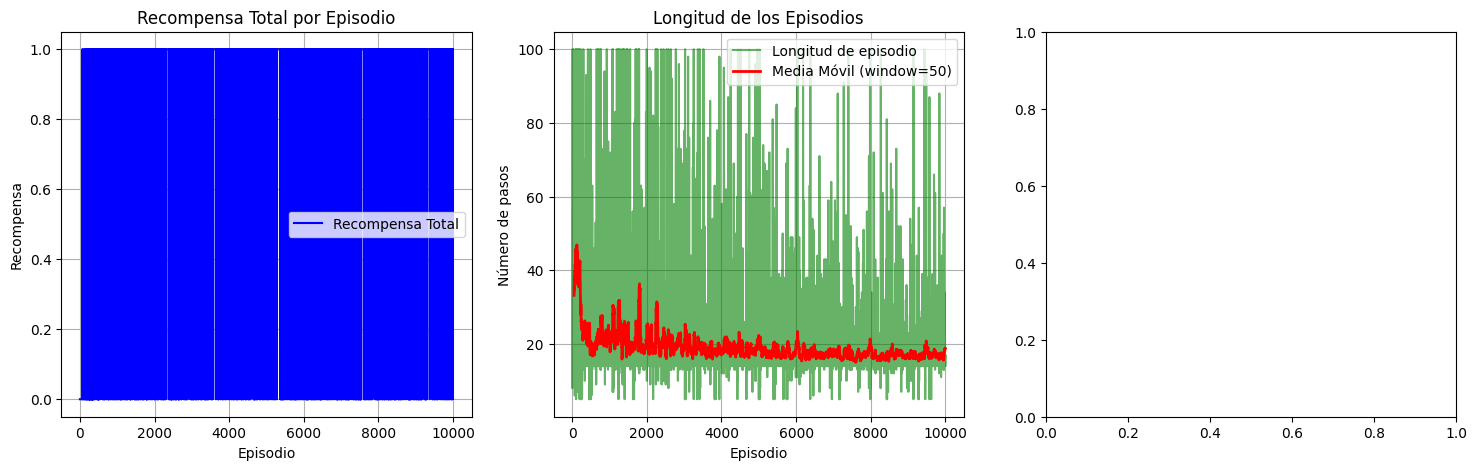

In [71]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# -------------------------------------------------
# Función para convertir el estado discreto a vector one-hot
# -------------------------------------------------
def one_hot(state, state_size):
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state] = 1.0
    return vec

# -------------------------------------------------
# Wrapper para el entorno Frozen Lake
# -------------------------------------------------
class FrozenLakeWrapper:
    def __init__(self, is_slippery=True):
        self.env = gym.make('FrozenLake-v1', is_slippery=is_slippery, map_name="8x8")
        self.action_space = self.env.action_space  # Discrete(4)
        self.observation_space = self.env.observation_space  # Discrete(n)
    
    def reset(self):
        # Gymnasium devuelve (observation, info)
        result = self.env.reset()
        if isinstance(result, tuple):
            return result[0]
        return result
    
    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
            return obs, reward, done, info
        else:
            return result
    
    def render(self):
        self.env.render()

# -------------------------------------------------
# Definición de la red neuronal para SARSA
# -------------------------------------------------
class SarsaNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(SarsaNet, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------------------------------
# Agente SARSA con aproximación semigradiente
# -------------------------------------------------
class SarsaAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                 epsilon=1.0, min_epsilon=0.1, decay_rate=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        
        self.model = SarsaNet(state_size, action_size, hidden_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
    
    def choose_action(self, state):
        # Política epsilon-greedy
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state_tensor)
            return q_values.argmax().item()
    
    def update(self, state, action, reward, next_state, next_action, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        
        # Q(s, a) actual
        q_value = self.model(state_tensor)[0, action]
        
        with torch.no_grad():
            if done:
                target = reward
            else:
                target = reward + self.gamma * self.model(next_state_tensor)[0, next_action]
        target = torch.tensor(target)
        
        loss = self.criterion(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.decay_rate, self.min_epsilon)

# -------------------------------------------------
# Función para pintar los 3 gráficos al final
# -------------------------------------------------
def plot_all_three(list_stats, episode_lengths, Q, env, actions, window=50):
    """
    Muestra en una sola figura:
      1) Recompensa total por episodio.
      2) Longitud de los episodios (con media móvil).
      3) Política aprendida en el entorno (flechas).

    Parámetros:
    -----------
    list_stats : list
        Lista con las recompensas totales por episodio.
    episode_lengths : list
        Lista con la longitud (número de pasos) de cada episodio.
    Q : np.ndarray
        Q-table con dimensiones [n_estados, n_acciones].
    env : gym.Env
        Entorno FrozenLake (ej. FrozenLake-v1).
    actions : list[int]
        Lista de enteros (0,1,2,3) que representan la política escogida por el agente.
    window : int
        Tamaño de la ventana para calcular la media móvil de la longitud de episodios.
    """
    
    # Crear la figura con 3 subplots en una fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) Recompensa total por episodio
    indices = list(range(len(list_stats)))
    ax1.plot(indices, list_stats, label="Recompensa Total", color="blue")
    ax1.set_title("Recompensa Total por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.grid(True)
    ax1.legend()
    
    # 2) Longitud de episodios (con media móvil)
    indices = list(range(len(episode_lengths)))
    ax2.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6, color="green")
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode="valid")
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg,
                 label=f"Media Móvil (window={window})", color='red', linewidth=2)
    ax2.set_title("Longitud de los Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Número de pasos")
    ax2.grid(True)
    ax2.legend()
    
    # 3) Política aprendida (mapa de FrozenLake con flechas)
    arrow_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    num_filas, num_columnas = env.unwrapped.desc.shape
    best_actions = [np.argmax(Q[s]) for s in range(env.observation_space.n)]
    best_actions_2d = np.reshape(best_actions, (num_filas, num_columnas))
    
    ax3.set_xlim(-0.5, num_columnas - 0.5)
    ax3.set_ylim(num_filas - 0.5, -0.5)
    
    # Dibujar cada celda con su color según el tipo
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                color = "gray"
            elif celda == 'G':
                color = "green"
            elif celda == 'F':
                color = "skyblue"
            elif celda == 'H':
                color = "red"
            else:
                color = "white"
            ax3.add_patch(plt.Rectangle((columna - 0.5, fila - 0.5),
                                        1, 1, color=color, ec="black"))
    
    # Añadir texto en cada celda
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                ax3.text(columna, fila, "Start", ha="center", va="center",
                         fontsize=12, color="white", fontweight="bold")
            elif celda in ['H', 'G']:
                ax3.text(columna, fila, celda, ha="center", va="center",
                         fontsize=14, color="white", fontweight="bold")
            else:
                accion_optima = best_actions_2d[fila, columna]
                flecha = arrow_dict.get(accion_optima, '?')
                ax3.text(columna, fila, flecha, ha="center", va="center",
                         fontsize=16, color="black", fontweight="bold")
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Política Aprendida", pad=10)
    
    # Leyenda de flechas y colores
    left_arrow = mlines.Line2D([], [], color='black', marker=r'$\leftarrow$', 
                               linestyle='None', markersize=12, label='Acción 0: Izquierda')
    down_arrow = mlines.Line2D([], [], color='black', marker=r'$\downarrow$', 
                               linestyle='None', markersize=12, label='Acción 1: Abajo')
    right_arrow = mlines.Line2D([], [], color='black', marker=r'$\rightarrow$', 
                                linestyle='None', markersize=12, label='Acción 2: Derecha')
    up_arrow = mlines.Line2D([], [], color='black', marker=r'$\uparrow$', 
                             linestyle='None', markersize=12, label='Acción 3: Arriba')
    patch_s = mpatches.Patch(color="gray", label="S (Inicio)")
    patch_f = mpatches.Patch(color="skyblue", label="F (Hielo)")
    patch_h = mpatches.Patch(color="red", label="H (Agua)")
    patch_g = mpatches.Patch(color="green", label="G (Meta)")
    
    policy_str = str(actions)
    policy_line = mlines.Line2D([], [], color='none', marker='',
                                linestyle='None', markersize=12, label=f"\n Política escogida: {policy_str}")
    
    legend_handles = [left_arrow, down_arrow, right_arrow, up_arrow,
                      patch_s, patch_f, patch_h, patch_g,
                      policy_line]
    
    ax3.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
               loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Integración y entrenamiento (SARSA semigradiente)
# -------------------------------------------------

# Crear el entorno y definir dimensiones
env_wrapper = FrozenLakeWrapper(is_slippery=False)
state_size = env_wrapper.observation_space.n   # Ej: 16 para 4x4
action_size = env_wrapper.action_space.n         # Normalmente 4

# Crear el agente SARSA
agent = SarsaAgent(state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                   epsilon=1.0, min_epsilon=0.1, decay_rate=0.995)

num_episodes = 10000
episode_rewards = []   # Para la recompensa total de cada episodio
episode_lengths = []   # Para almacenar la longitud (número de pasos) de cada episodio

for episode in range(num_episodes):
    state = env_wrapper.reset()
    state_one_hot = one_hot(state, state_size)
    action = agent.choose_action(state_one_hot)
    total_reward = 0
    steps = 0
    done = False
    
    while not done:
        next_state, reward, done, info = env_wrapper.step(action)
        next_state_one_hot = one_hot(next_state, state_size)
        next_action = agent.choose_action(next_state_one_hot) if not done else None
        
        # Actualización en línea: semi-gradient SARSA
        agent.update(state_one_hot, action, reward, next_state_one_hot, next_action, done)
        
        state_one_hot = next_state_one_hot
        action = next_action if not done else None
        total_reward += reward
        steps += 1
        
    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1}, Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

# Calcular la Q-table a partir del modelo entrenado
Q_table = np.zeros((state_size, action_size))
for s in range(state_size):
    s_one_hot = one_hot(s, state_size)
    with torch.no_grad():
        Q_table[s] = agent.model(torch.FloatTensor(s_one_hot).unsqueeze(0)).numpy()[0]

# Extraer la política (la mejor acción para cada estado)
policy_actions = [np.argmax(Q_table[s]) for s in range(state_size)]

# Llamar a la función de graficación con los datos recolectados
plot_all_three(episode_rewards, episode_lengths, Q_table, env_wrapper, policy_actions, window=50)


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def plot_all_three(list_stats, episode_lengths, Q, env, actions, window=50):
    """
    Muestra en una sola figura:
      1) Recompensa total por episodio.
      2) Longitud de los episodios (con media móvil).
      3) Política aprendida en el entorno (flechas).

    Parámetros:
    -----------
    list_stats : list
        Lista con las recompensas totales por episodio.
    episode_lengths : list
        Lista con la longitud (número de pasos) de cada episodio.
    Q : np.ndarray
        Q-table con dimensiones [n_estados, n_acciones].
    env : gym.Env o wrapper
        Entorno FrozenLake (ej. FrozenLake-v1). Si es un wrapper, se accederá a env.env.
    actions : list[int]
        Lista de enteros (0,1,2,3) que representan la política escogida por el agente.
    window : int
        Tamaño de la ventana para calcular la media móvil de la longitud de episodios.
    """
    
    # Usamos el entorno interno si se trata de un wrapper
    if hasattr(env, 'env'):
        env_inner = env.env
    else:
        env_inner = env
    
    # Crear la figura con 3 subplots en una fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) Recompensa total por episodio
    indices = list(range(len(list_stats)))
    ax1.plot(indices, list_stats, label="Recompensa Total", color="blue")
    ax1.set_title("Recompensa Total por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.grid(True)
    ax1.legend()
    
    # 2) Longitud de episodios (con media móvil)
    indices = list(range(len(episode_lengths)))
    ax2.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6, color="green")
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode="valid")
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg,
                 label=f"Media Móvil (window={window})", color='red', linewidth=2)
    ax2.set_title("Longitud de los Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Número de pasos")
    ax2.grid(True)
    ax2.legend()
    
    # 3) Política aprendida (mapa de FrozenLake con flechas)
    arrow_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    num_filas, num_columnas = env_inner.unwrapped.desc.shape
    best_actions = [np.argmax(Q[s]) for s in range(env_inner.observation_space.n)]
    best_actions_2d = np.reshape(best_actions, (num_filas, num_columnas))
    
    ax3.set_xlim(-0.5, num_columnas - 0.5)
    ax3.set_ylim(num_filas - 0.5, -0.5)
    
    # Dibujar cada celda con su color según el tipo
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                color = "gray"
            elif celda == 'G':
                color = "green"
            elif celda == 'F':
                color = "skyblue"
            elif celda == 'H':
                color = "red"
            else:
                color = "white"
            ax3.add_patch(plt.Rectangle((columna - 0.5, fila - 0.5),
                                        1, 1, color=color, ec="black"))
    
    # Añadir texto en cada celda
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                ax3.text(columna, fila, "Start", ha="center", va="center",
                         fontsize=12, color="white", fontweight="bold")
            elif celda in ['H', 'G']:
                ax3.text(columna, fila, celda, ha="center", va="center",
                         fontsize=14, color="white", fontweight="bold")
            else:
                accion_optima = best_actions_2d[fila, columna]
                flecha = arrow_dict.get(accion_optima, '?')
                ax3.text(columna, fila, flecha, ha="center", va="center",
                         fontsize=16, color="black", fontweight="bold")
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Política Aprendida", pad=10)
    
    # Leyenda de flechas y colores
    left_arrow = mlines.Line2D([], [], color='black', marker=r'$\leftarrow$', 
                               linestyle='None', markersize=12, label='Acción 0: Izquierda')
    down_arrow = mlines.Line2D([], [], color='black', marker=r'$\downarrow$', 
                               linestyle='None', markersize=12, label='Acción 1: Abajo')
    right_arrow = mlines.Line2D([], [], color='black', marker=r'$\rightarrow$', 
                                linestyle='None', markersize=12, label='Acción 2: Derecha')
    up_arrow = mlines.Line2D([], [], color='black', marker=r'$\uparrow$', 
                             linestyle='None', markersize=12, label='Acción 3: Arriba')
    patch_s = mpatches.Patch(color="gray", label="S (Inicio)")
    patch_f = mpatches.Patch(color="skyblue", label="F (Hielo)")
    patch_h = mpatches.Patch(color="red", label="H (Agua)")
    patch_g = mpatches.Patch(color="green", label="G (Meta)")
    
    policy_str = str(actions)
    policy_line = mlines.Line2D([], [], color='none', marker='',
                                linestyle='None', markersize=12, label=f"\n Política escogida: {policy_str}")
    
    legend_handles = [left_arrow, down_arrow, right_arrow, up_arrow,
                      patch_s, patch_f, patch_h, patch_g,
                      policy_line]
    
    ax3.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
               loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()


C:\Users\pacol\AppData\Local\Temp\ipykernel_6108\3207665095.py:131: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


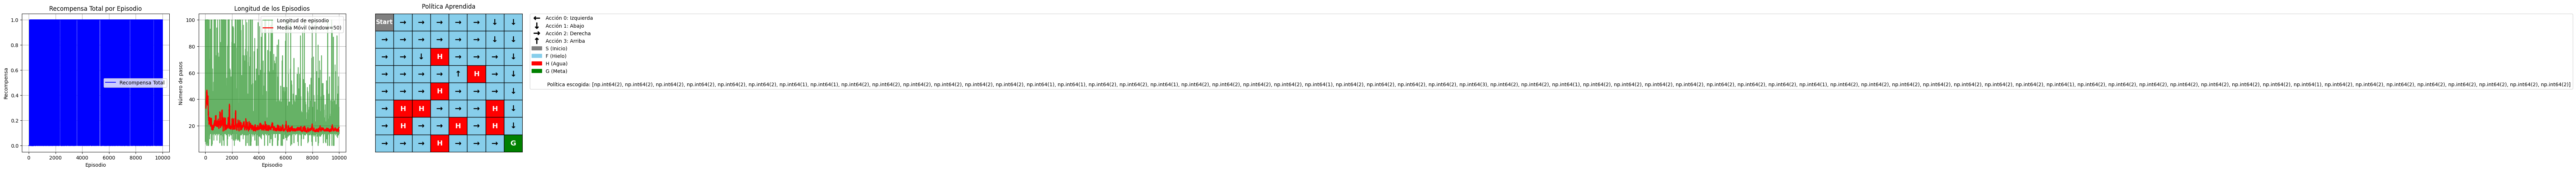

In [ ]:
# Crear una instancia del wrapper para Frozen Lake (8x8, no resbaladizo)
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="8x8")

# Crear el agente SARSA semigradiente
num_episodios = 10000
agent = SarsaNet(env_wrapper, epsilon=1.0, gamma=0.99, learning_rate=0.001, 
                            min_epsilon=0.1, decay_rate=0.995, hidden_size=64, seed=42)

# Entrenar el agente
rewards, lengths = agent.entrenar(num_episodios)
